### **Variational Physics Informed Neural Network**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import optim
from numpy.polynomial import legendre as leg
from scipy.integrate import quad
from scipy.linalg import eigh

In [2]:
def style_plot(x, y, x_data, y_data, yh, xp=None):
    style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.plot(x, yh, label="Neural network prediction")
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations')
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')

**Método de Integración**

Cuadratura Gaussiana

In [3]:
def gauss_quad_manual(func, a, b, n):
    """
    Approximate the integral of a function using Gaussian quadrature.

    Parameters:
    func (function): The function to integrate.
    a (float): The start of the integration interval.
    b (float): The end of the integration interval.
    n (int): The number of nodes to use for the approximation.

    Returns:
    float: The approximate integral of the function over the interval [a, b].
    """    
    nodes = leg.legroots(leg.legder([0]*n + [1]))
    
    weights = 2 / ((1 - nodes**2) * (leg.legval(nodes, leg.legder([0]*(n-1) + [1], m=2)))**2)
    
    t = 0.5*(nodes + 1)*(b - a) + a
    
    integral = np.sum(weights * func(t)) * 0.5*(b - a)

    return integral

**Método de Diferenciación**

In [4]:
def central_difference(v, x):
    """
    Calculates the central difference approximation of the derivative of a function.

    Parameters:
    v (array-like): The values of the function.
    x (array-like): The corresponding x-values.

    Returns:
    array-like: The central difference approximation of the derivative.
    """
    h = x[1] - x[0]  
    dv = (v[2:] - v[:-2]) / (2*h)
    return dv

**Funciones de Test con FEM Helmholtz**

In [49]:
def FEM1D(coords):
    N = len(coords)
    stiff_loc = np.array([[2.0, -2.0],
                          [-2.0, 2.0]])
    mass_loc = np.array([[2/3, 1/3],
                         [1/3, 2/3]])
    eles = [np.array([cont, cont + 1]) for cont in range(0, N - 1)]
    stiff = np.zeros((N, N))
    mass = np.zeros((N, N))
    for ele in eles:  ## Ensamblaje
        jaco = coords[ele[1]] - coords[ele[0]]
        for cont1, row in enumerate(ele):
            for cont2, col in enumerate(ele):
                stiff[row, col] = stiff[row, col] +  stiff_loc[cont1, cont2]/jaco
                mass[row, col] = mass[row, col] +  jaco*mass_loc[cont1, cont2]
    return stiff, mass

# Caso de ejemplo
N = 100
nvals = 20
x = np.linspace(0, 1, N)

# FEM1D
stiff, mass = FEM1D(x)

# Vectores propios
vals, vecs = eigh(stiff[1:-1, 1:-1],
                  mass[1:-1, 1:-1],
                  subset_by_index=(0, nvals - 1))

vecs_comp = np.zeros((N, nvals))
vecs_comp[1:-1, :] = vecs

# Interpolación
x_eval = torch.linspace(0, 1, 1000)
v_eval = np.interp(x_eval, x, vecs_comp[:, 8])
v_eval = v_eval.reshape(1000, 1)
v_eval.shape 

(1000, 1)

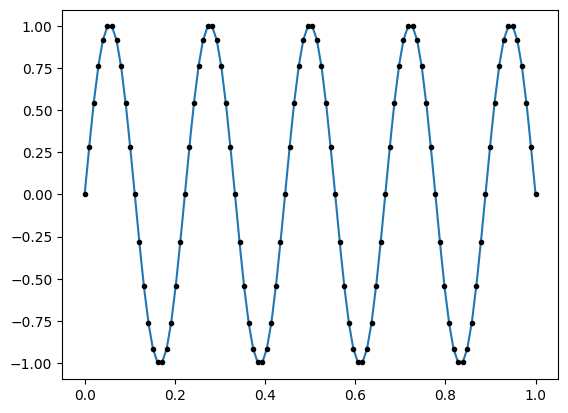

In [50]:
plt.figure()
plt.plot(x_eval, v_eval)
plt.plot(x, vecs_comp[:, 8], ".k")

**Arquitectura de Red Neuronal**

In [7]:
class FCN(nn.Module):  
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
        self.fch = nn.Sequential(*[
                    nn.Sequential(*[
                        nn.Linear(N_HIDDEN, N_HIDDEN),
                        activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Formulación problema

In [8]:
def f_rhs(x):
  return -4*torch.sin(2 * x)

def exact_u(x):
  return torch.sin(2 * x)

**Variational Neural Network**

Variational Loss

Loss at iteration 50: 1.749746918678284
Loss at iteration 100: 0.490685909986496
Loss at iteration 150: 0.002331985859200
Loss at iteration 200: 0.000070116482675
Loss at iteration 250: 0.000040922484914
Loss at iteration 300: 0.000036652167182
Loss at iteration 350: 0.000001371852477
Loss at iteration 400: 0.000005611109373
Loss at iteration 450: 0.000001371573262
Loss at iteration 500: 0.000000172841737
Loss at iteration 550: 0.000011347373402
Loss at iteration 600: 0.000005047695595
Loss at iteration 650: 0.000000466461444
Loss at iteration 700: 0.000012184267689
Loss at iteration 750: 0.000002293196985
Loss at iteration 800: 0.000005721492926
Loss at iteration 850: 0.000005151877303
Loss at iteration 900: 0.000002363499561
Loss at iteration 950: 0.000000289402806
Loss at iteration 1000: 0.000001613950189


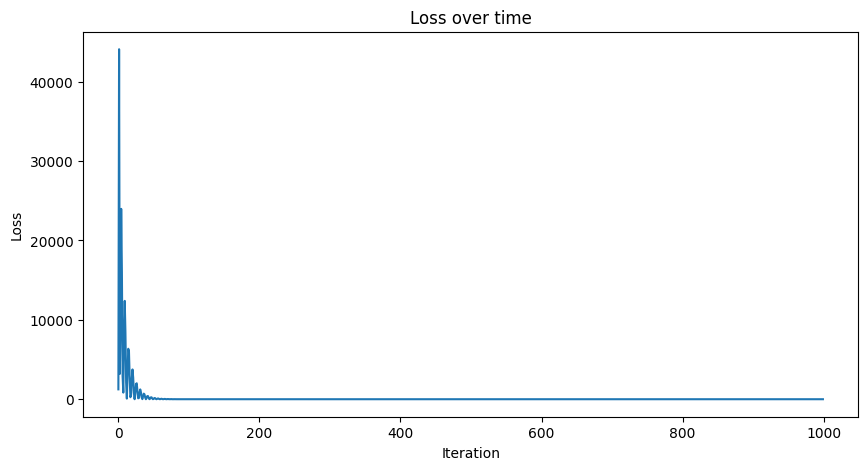

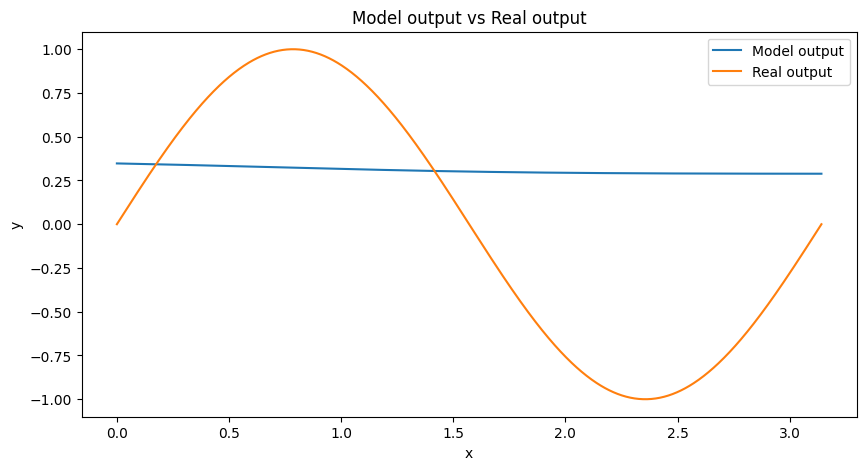

In [85]:
def compute_integral(y, x):
    dy = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
    integral = torch.trapz(dy, x, dim=0)
    return integral

def compute_loss(model, x, v, f_rhs):
    u = model(x)
    du = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]    
    dv = torch.autograd.grad(v.sum(), x, create_graph=True)[0]   

    integral_left = compute_integral(du * dv, x)
    integral_right = compute_integral(f_rhs * v, x)

    error_PDE = integral_left - integral_right
    bc = model(torch.tensor([np.pi]))**2 + model(torch.tensor([0.]))**2 
    loss = torch.mean((error_PDE + bc)**2)    
    return loss

def compute_L2_error(model, x, exact_u):
    exact_function = exact_u(x)
    predicted_function = model(x).detach()

    error_between_arrays = exact_function - predicted_function
    delta_x = x[1:] - x[:-1]

    L2_error = (error_between_arrays[:-1] + error_between_arrays[1:]) / 2 
    L2_output = torch.sqrt(torch.sum(delta_x * (L2_error**2)))
    return L2_output.item()

def main():
    N = 100
    n_pts = 1000
    iterations = 1000

    torch.manual_seed(123)
    model = FCN(1, 1, 10, 4)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    L2_errors = []

    x = torch.linspace(0, torch.pi, n_pts).requires_grad_(True).view(n_pts, 1)    

    n = torch.arange(1, n_pts + 1).float()
    test_funcs = lambda x: torch.sin(torch.pi * n.view(-1, 1) * x)
    v = test_funcs(x)
    #v = torch.from_numpy(np.interp(x.detach().numpy(), np.linspace(0, 1, N), vecs_comp[:, 8])).float().requires_grad_(True).view(n_pts, 1) 
    f_rhs_val = f_rhs(x)

    for i in range(iterations):
        optimizer.zero_grad()

        loss = compute_loss(model, x, v, f_rhs_val)
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        L2_errors.append(compute_L2_error(model, x, exact_u))
        if (i+1) % 50 == 0:
            print(f"Loss at iteration {i+1}: {loss.item():.15f}")

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss over time')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    x_test = torch.linspace(0, np.pi, n_pts).view(n_pts, 1)
    y_test = model(x_test).detach().numpy()
    y_real = exact_u(x_test).detach().numpy()  

    plt.figure(figsize=(10, 5))
    plt.plot(x_test.numpy(), y_test, label='Model output')
    plt.plot(x_test.numpy(), y_real, label='Real output')
    plt.title('Model output vs Real output')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [77]:
n = torch.arange(1, 1000 + 1).float()
test_funcs = lambda x: torch.sin(torch.pi * n.view(-1, 1) * x)
v = test_funcs(x)
v

tensor([[ 0.0000,  0.0099,  0.0198,  ..., -0.4124, -0.4214, -0.4303],
        [ 0.0000,  0.0198,  0.0395,  ...,  0.7514,  0.7643,  0.7769],
        [ 0.0000,  0.0296,  0.0592,  ..., -0.9566, -0.9648, -0.9722],
        ...,
        [ 0.0000, -0.4214,  0.7643,  ..., -0.1029,  0.5121, -0.8267],
        [ 0.0000, -0.4303,  0.7769,  ...,  0.5037, -0.8267,  0.9883],
        [ 0.0000, -0.4392,  0.7891,  ..., -0.8150,  0.9868, -0.9576]],
       grad_fn=<SinBackward0>)

In [80]:
v_derivada = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
v_derivada.shape

torch.Size([1000])